<a href="https://colab.research.google.com/github/gsarm78/cs230Project/blob/master/nowcastingmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/gsarm78/cs230Project.git

Cloning into 'cs230Project'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 135 (delta 24), reused 109 (delta 10), pack-reused 0
Receiving objects: 100% (135/135), 8.71 MiB | 15.07 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
# DATA LOADING AND PROCESSING INTO NUMPY ARRAY

import numpy as np
from PIL import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  ### NO WARNINGS!
import time

IMAGE_PATH = '/content/cs230Project/samples'


WIDTH = 100
HEIGHT = 100
SEQUENCE = np.array([])
BASIC_SEQUENCE = np.array([])
NEXT_SEQUENCE = np.array([])
NUMBER = 0

def image_initialize(image):
    picture = Image.open(image)
    picture = picture.crop((243, 176, 1428, 1280))
    picture = picture.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    picture = picture.convert('L')
    data = np.array(picture.getdata()).reshape(WIDTH, HEIGHT, 1)
    return data

for file in os.listdir(IMAGE_PATH):
    image_array = image_initialize(os.path.join(IMAGE_PATH, file))
    SEQUENCE = np.append(SEQUENCE, image_array)
    NUMBER += 1

SEQUENCE = SEQUENCE.reshape(NUMBER, WIDTH * HEIGHT)

for i in SEQUENCE:
    for j in range(int(len(i))):
        if i[j] < 50:
            i[j] = 0

np.savez('/content/cs230Project/data/images_sequence_array.npz', sequence_array=SEQUENCE)
print('Data (images) saved as numpy compressed array')
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

Data (images) saved as numpy compressed array
2020-02-22 00:24:23


In [0]:
#!pip install tensorflow==1.14.0

In [4]:
# LOADING OF NUMPY ARRAY INTO SEQUENCES #
#########################################
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import pylab as plt

FRAMES = 16 #frames to process

SEQUENCE = np.load('/content/cs230Project/data/images_sequence_array.npz')['sequence_array']  # load array
print('Image Sequence Data loaded.')
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

# Number of input images in the sequence
NUMBER = len(SEQUENCE)

# step =1
SEQUENCE = SEQUENCE.reshape(NUMBER, WIDTH, HEIGHT, 1)
# step =2
SEQUENCE_2 = []
for i in range(int(NUMBER / 2)):
    SEQUENCE_2.append(SEQUENCE[2 * i])
# step = 3
SEQUENCE_3 = []
for i in range(int(NUMBER / 3)):
    SEQUENCE_3.append(SEQUENCE[3 * i])


SEQUENCE = SEQUENCE.reshape(NUMBER, WIDTH, HEIGHT, 1)
BASIC_SEQUENCE = np.zeros((NUMBER-FRAMES, FRAMES, WIDTH, HEIGHT, 1))
NEXT_SEQUENCE = np.zeros((NUMBER-FRAMES, FRAMES, WIDTH, HEIGHT, 1))


for i in range(FRAMES):
    #print(i)
    BASIC_SEQUENCE[:, i, :, :, :] = SEQUENCE[i:i+NUMBER-FRAMES]
    NEXT_SEQUENCE[:, i, :, :, :] = SEQUENCE[i+1:i+NUMBER-FRAMES+1]
print("Input sequence ready")

Image Sequence Data loaded.
2020-02-22 00:25:24
Input sequence ready


In [0]:
# CONVLSTM Model architecture
model = Sequential()

model.add(ConvLSTM2D(filters=48, kernel_size=(3, 3),input_shape=(None, WIDTH, HEIGHT, 1), padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=24, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=12, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=6, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last'))

model.compile(loss='logcosh', optimizer='adam', metrics=['acc'])

history = model.fit(BASIC_SEQUENCE[:40], NEXT_SEQUENCE[:40], batch_size=5, epochs=180, validation_split=0.05, verbose=1)

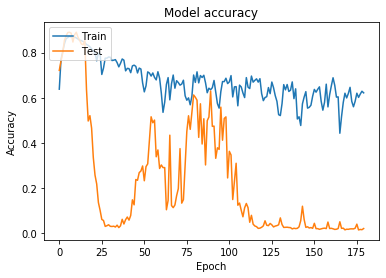

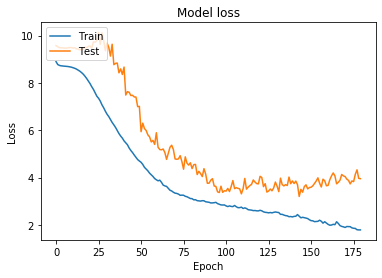

In [12]:
####################################
#         PLOT LOSS vs EPOCHS      #
####################################

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# Model Summary; Training parameters etc...
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_11 (ConvLSTM2D) (None, None, 100, 100, 48 84864     
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 100, 100, 48 192       
_________________________________________________________________
conv_lst_m2d_12 (ConvLSTM2D) (None, None, 100, 100, 24 62304     
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 100, 100, 24 96        
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, None, 100, 100, 12 15600     
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 100, 100, 12 48        
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, None, 100, 100, 6)

In [0]:
#Save trained model 
model.save('/content/cs230Project/model/trained_model.h5')

In [0]:
#which = 600
which = 20
track = BASIC_SEQUENCE[which][:10, ::, ::, ::]

In [0]:
for j in range(FRAMES+1):
    new_pos = model.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

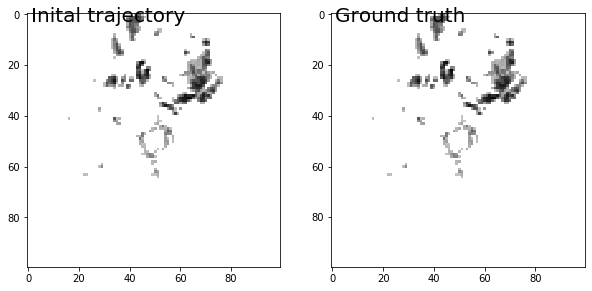

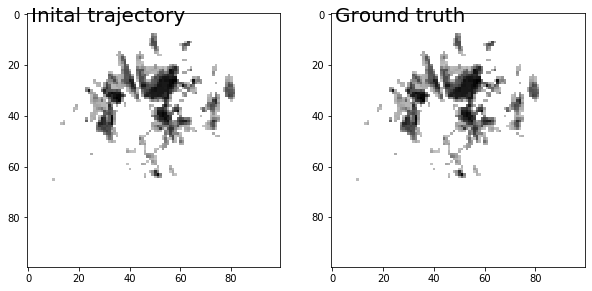

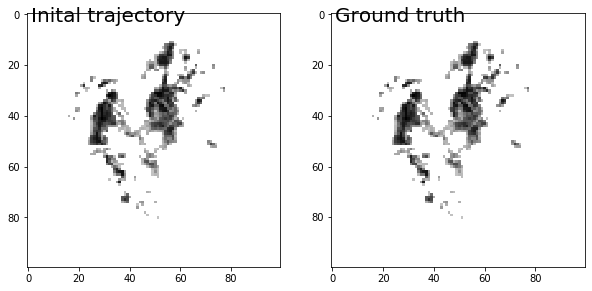

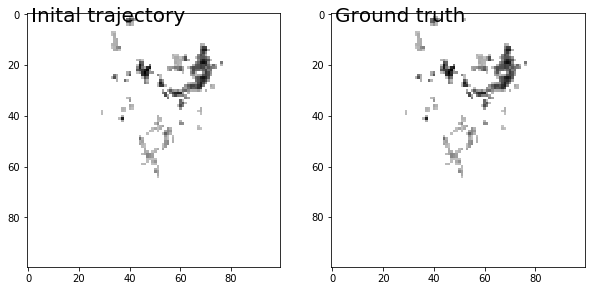

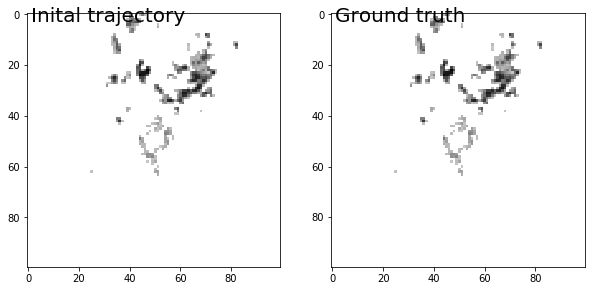

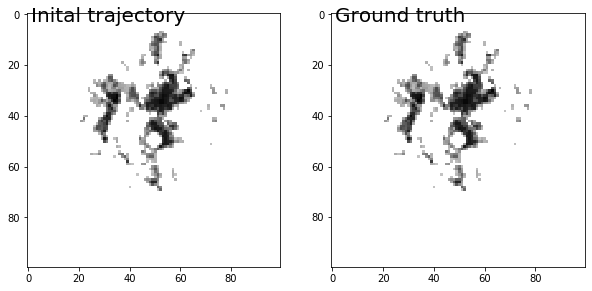

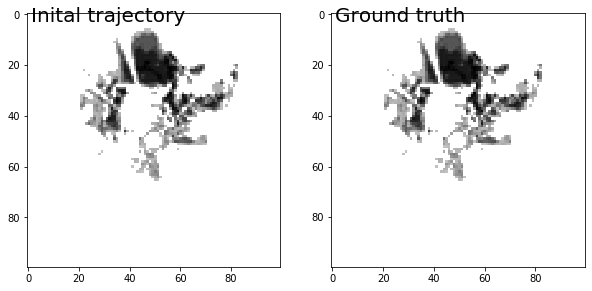

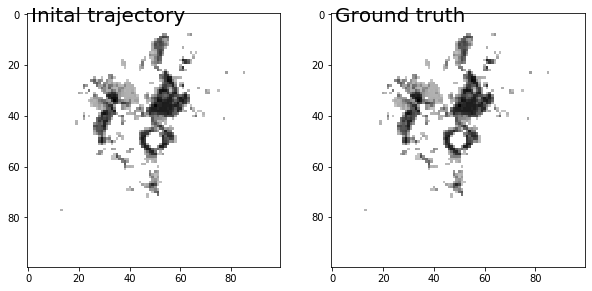

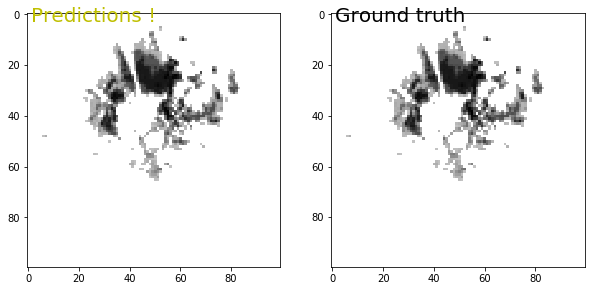

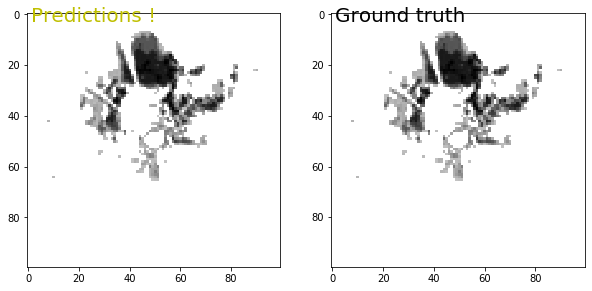

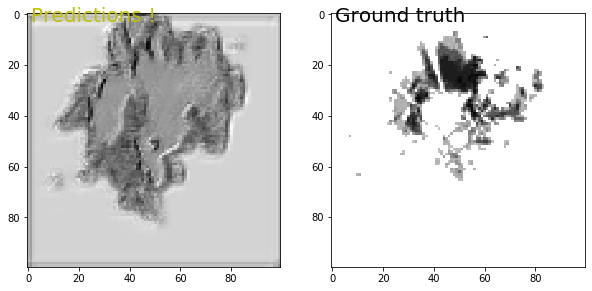

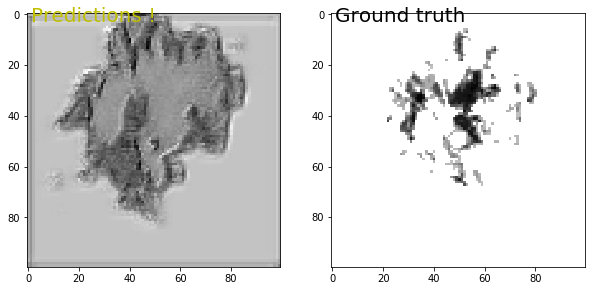

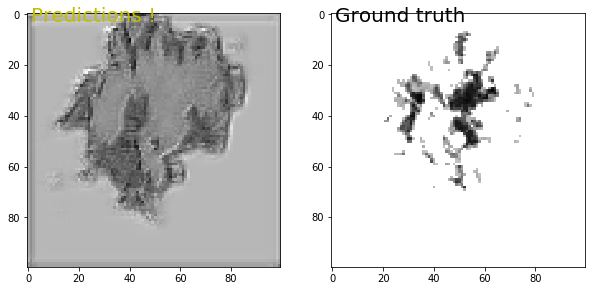

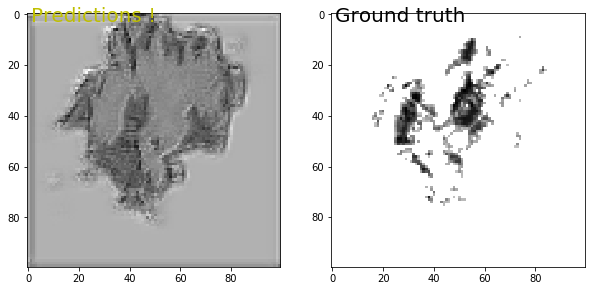

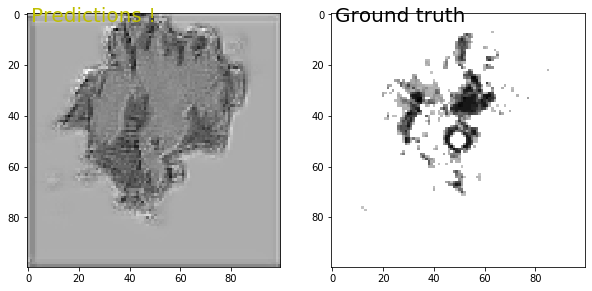

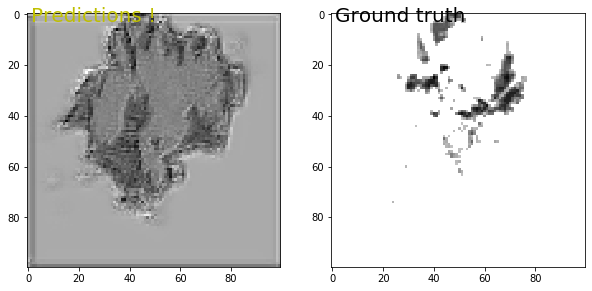

In [9]:
# And then compare the predictions
# to the ground truth
# Inspiration https://keras.io Documentation examples
track2 = BASIC_SEQUENCE[which][::, ::, ::, ::]
for i in range(FRAMES):
    fig = plt.figure(figsize=(10, 5))
    axes = fig.add_subplot(121)
    if i >= 8:
        axes.text(1, 3, 'Predictions !', fontsize=20, color='y')
    else:
        axes.text(1, 3, 'Inital trajectory', fontsize=20)
    toplot = track[i, ::, ::, 0]
    plt.imshow(toplot, cmap='binary')
    axes = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)
    toplot = track2[i, ::, ::, 0]
    if i >= 8:
        toplot = NEXT_SEQUENCE[which][i - 1, ::, ::, 0]
    plt.imshow(toplot, cmap='binary')
    plt.savefig('/content/cs230Project/data/prediction/%i_image.png' % (i + 1))